In [ ]:
# TensorFlow 2.0.0 is required for this code to work.
# Uncomment and run the following line to install the CPU version.
# !pip install tensorflow==2.0.0-beta0

### Import necessary modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from functools import reduce
import os
import json
from PIL import Image

### Get a list of all hashtags

In [2]:
json_file_names = os.listdir('json_files')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

In [3]:
hashtag_dfs = []
for hashtag in hashtags: 
    hashtag_dfs.append(pd.read_json(f'json_files/{hashtag}.json'))
df = reduce(lambda x, y: pd.concat([x, y]), hashtag_dfs)

In [4]:
full_list = pd.DataFrame.reset_index(df, drop=True)

In [5]:
full_list.tail()

,hashtags,image,image_local_name,post_link,search_hashtag
2995,[wedding],NaN,716d3685-76d5-42c5-9800-b345864028f7.jpg,NaN,wedding
2996,[wedding],NaN,3df95a2c-6c2e-4b97-a838-afa26253c24e.jpg,NaN,wedding
2997,[wedding],NaN,e01dc175-415e-4d03-a31e-9e2359f78bbf.jpg,NaN,wedding
2998,[wedding],NaN,90be6acf-4f6a-4010-a605-e1db26c436a0.jpg,NaN,wedding
2999,[wedding],NaN,6d4ca30e-d0b0-4bdc-a105-43a497feb882.jpg,NaN,wedding


### Resizing image to be used in tensorflow framework for Deep Feature Extraction

In [30]:
img_size = 160 # All images will be resized to 160x160
img_shape = (160, 160, 3)

def prepare_image(img_path, height=img_size, width=img_size):
    """Downsample and scale image to prepare it for neural network"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (height, width))
    # Reshape B&W images to match dimensions of color images
    if img.shape != (160, 160, 3):
        img = tf.concat([img, img, img], axis=2)
    return img

In [31]:
pics = []
for i, row in full_list.iterrows():
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path)
        pics.append({'pic': img, 'hashtag': hashtag})
    except:
        # If a file in the list isn't in 
        # storage, skip it and continue
        pass

In [32]:
type(pics[64]['pic'])

tensorflow.python.framework.ops.EagerTensor

W0621 00:16:23.157775 140735721816960 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


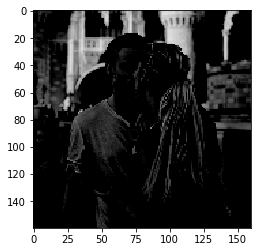

In [33]:
plt.imshow(pics[64]['pic']);

In [34]:
# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

In [35]:
def extract_features(image_dict):
    """Return a vector of 1280 deep features for image."""
    image = image_dict['pic']
    image_np = image.numpy()
    images_np = np.expand_dims(image_np, axis=0)
    image_np.shape, images_np.shape
    deep_features = neural_network.predict(images_np)
    image_dict['deep_features'] = deep_features[0]
    return image_dict

In [36]:
deep_features = list(map(extract_features, pics))

In [37]:
shuffle(deep_features)
train_size = int(len(deep_features) * .7)
train, test = deep_features[:train_size], deep_features[train_size:]

In [38]:
train[0].keys()

dict_keys(['pic', 'hashtag', 'deep_features'])

In [39]:
pic = train[0]

W0621 00:17:41.840357 140735721816960 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


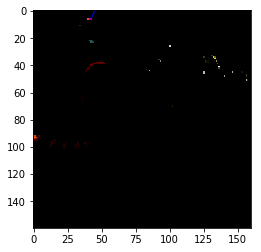

In [40]:
plt.imshow(pic['pic']);

In [41]:
pic['hashtag']

'selfie'

In [42]:
pic['deep_features'].shape

(1280,)

In [43]:
pic['pic'].shape

TensorShape([160, 160, 3])

In [ ]:
deep_features

## ALS Model

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel

In [7]:
spark = SparkSession.builder.master('local').getOrCreate()

In [8]:
full_list.loc[0, 'hashtags']

['#foodie',
 '#dinner',
 '#healthyfood',
 '#cooking',
 '#delicious',
 '#instafood',
 '#yummy',
 '#vegetables',
 '#love',
 '#grapes',
 '#organic',
 '#fruits',
 '#veganfood',
 '#foodstagram',
 '#health',
 '#fitness',
 '#fresh',
 '#vegan',
 '#healthylifestyle',
 '#foodphotography',
 '#lunch',
 '#nutrition',
 '#plantbased',
 '#healthy',
 '#vegetarian',
 '#veggies',
 '#food',
 '#fruit',
 '#salad',
 '#foodporn']

In [9]:
full_list.head()

,hashtags,image,image_local_name,post_link,search_hashtag
0,"[#foodie, #dinner, #healthyfood, #cooking, #de...",https://scontent-lga3-1.cdninstagram.com/vp/28...,af2f1fc3-9e44-4d08-b395-f2fcccc28f31.jpg,https://www.instagram.com/p/By5hfhMl8NI/,fitness
1,"[#modellife, #quoteoftheday, #beverlyhills, #k...",https://scontent-lga3-1.cdninstagram.com/vp/54...,213a8e3e-19d0-4dd1-b14d-a488fafee7b4.jpg,https://www.instagram.com/p/By5gtZ0gewQ/,fitness
2,"[#alphalete, #Physiquefreak, #Fitness, #Roadto...",https://scontent-lga3-1.cdninstagram.com/vp/e6...,9924a2fe-5629-4cba-a605-c361bb79d250.jpg,https://www.instagram.com/p/By5ewa6HmV1/,fitness
3,"[#dreamscape, #iphoneonly, #webstagram, #eyesg...",https://scontent-lga3-1.cdninstagram.com/vp/99...,2b648d11-42c4-41df-a12b-7bd93d200985.jpg,https://www.instagram.com/p/By5iJG8opWq/,fitness
4,"[#workhard, #melone, #trainmean, #germany, #ma...",https://scontent-lga3-1.cdninstagram.com/vp/2f...,3b886314-91f4-43af-a30c-cf2b254de662.jpg,https://www.instagram.com/p/By5fCtwCBcK/,fitness


In [10]:
full_list['clean_hashtags'] = full_list['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

In [11]:
image_lookup = dict(zip(full_list['image_local_name'], full_list.index))

In [12]:
all_hashtags = set()
for tags in full_list['clean_hashtags']:
    all_hashtags.update(tags)
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [13]:
hashtag_data = []
for i in full_list.index:
    hashtags = full_list.loc[i, 'clean_hashtags']
    for hashtag in hashtags:
        hashtag_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_df_long = pd.DataFrame(hashtag_data)

In [14]:
hashtag_df_long.tail()

,hashtag_id,image_id,rating
36041,1154,2699,1
36042,3901,2699,1
36043,1142,2699,1
36044,9116,2699,1
36045,11523,2699,1


In [15]:
full_list.dtypes

hashtags            object
image               object
image_local_name    object
post_link           object
search_hashtag      object
clean_hashtags      object
dtype: object

In [16]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

In [17]:
hashtag_spark_df = spark.createDataFrame(hashtag_df_long)

In [18]:
als_model = als.fit(hashtag_spark_df)

In [19]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()

In [20]:
hashtag_index = list(all_hashtags)

In [21]:
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

In [22]:
def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [23]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)

In [24]:
recs.index = recs['image_id']

In [25]:
compare_recs = recs.join(full_list, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [26]:
compare_recs.drop('recommendations', axis=1)

,recommended_hashtags,hashtags,image_local_name,search_hashtag
image_id,,,,
1580,"[#cars, #jdm, #ford, #car, #bmw, #toyota, #fer...","[#gt, #toyota, #ej, #r, #wrx, #impreza, #bmw, ...",98b75f05-52d5-460d-9580-f95f0f86f353.jpg,cars
1591,"[#cars, #car, #auto, #bmw, #carporn, #carlifes...","[#bpautomobilemachtsm, #bpautomobile, #weilwir...",ba04590d-a8f1-495b-aa9e-b3cc575048fc.jpg,cars
463,"[#selfie, #follow, #instagood, #food, #like, #...","[#instagood, #instadaily, #koreanfood, #selca,...",e4ec8a33-df23-4d5e-b8b0-52168ba37a06.jpg,selfie
833,"[#travel, #art, #architecture, #green, #street...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel
1645,"[#cars, #car, #bmw, #auto, #toyota, #ford, #me...","[#toyota, #minicarros, #vendas, #vendasonline,...",3cd627fc-a80d-4ed0-86c9-33f5c80f562d.jpg,cars
1829,"[#food, #foodporn, #instafood, #foodie, #foods...","[#bhcidadecriativadagastronomia, #prato, #come...",56018a9a-8def-48d1-9a7d-03136314b0d9.jpg,food
1959,"[#instafood, #foodie, #foodporn, #foodstagram,...","[#hagerstownmd, #washingtoncountymd, #hswhmdbu...",2b98b605-8df1-4fcb-addf-887751caaaaa.jpg,food
2659,"[#pets, #animals, #dogs, #animal, #pet, #dogst...","[#sportdogminsk, #dogminsk, #labrador, #labrad...",c62f34b0-da93-485c-94a0-d56be4b72018.jpg,animals
540,"[#selfie, #ootd, #f, #l, #daily, #selca, #girl...","[#tomboy, #hotel, #photobook, #selfie, #mirror]",f4963853-1824-4c44-a6d5-4f8059eb4c56.jpg,selfie


In [27]:
image_factors = als_model.userFactors.toPandas()

In [28]:
image_factors.index = image_factors['id']

In [29]:
compare_recs.join(image_factors)

,recommendations,recommended_hashtags,hashtags,image_local_name,search_hashtag,id,features
image_id,,,,,,,
1580,"[(11130, 1.0610136985778809), (2788, 1.0605531...","[#cars, #jdm, #ford, #car, #bmw, #toyota, #fer...","[#gt, #toyota, #ej, #r, #wrx, #impreza, #bmw, ...",98b75f05-52d5-460d-9580-f95f0f86f353.jpg,cars,1580,"[0.17118602991104126, -0.9873420000076294, 0.5..."
1591,"[(11130, 0.7959606051445007), (10021, 0.664359...","[#cars, #car, #auto, #bmw, #carporn, #carlifes...","[#bpautomobilemachtsm, #bpautomobile, #weilwir...",ba04590d-a8f1-495b-aa9e-b3cc575048fc.jpg,cars,1591,"[-0.09387083351612091, -0.3323621451854706, 0...."
463,"[(2204, 0.965850293636322), (4236, 0.919204950...","[#selfie, #follow, #instagood, #food, #like, #...","[#instagood, #instadaily, #koreanfood, #selca,...",e4ec8a33-df23-4d5e-b8b0-52168ba37a06.jpg,selfie,463,"[-0.07504117488861084, -0.09916742891073227, 0..."
833,"[(10353, 0.9407327771186829), (961, 0.87604045...","[#travel, #art, #architecture, #green, #street...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel,833,"[-0.2288348376750946, 0.49050676822662354, 0.4..."
1645,"[(11130, 0.7110134959220886), (10021, 0.520232...","[#cars, #car, #bmw, #auto, #toyota, #ford, #me...","[#toyota, #minicarros, #vendas, #vendasonline,...",3cd627fc-a80d-4ed0-86c9-33f5c80f562d.jpg,cars,1645,"[-0.0839998871088028, -0.41801917552948, 0.232..."
1829,"[(126, 0.7572681307792664), (5465, 0.586064636...","[#food, #foodporn, #instafood, #foodie, #foods...","[#bhcidadecriativadagastronomia, #prato, #come...",56018a9a-8def-48d1-9a7d-03136314b0d9.jpg,food,1829,"[0.07471337169408798, 0.27293887734413147, 0.0..."
1959,"[(5797, 1.0740387439727783), (9906, 1.04840385...","[#instafood, #foodie, #foodporn, #foodstagram,...","[#hagerstownmd, #washingtoncountymd, #hswhmdbu...",2b98b605-8df1-4fcb-addf-887751caaaaa.jpg,food,1959,"[0.6003634333610535, 0.43791916966438293, 0.06..."
2659,"[(170, 0.8584698438644409), (2397, 0.851038575...","[#pets, #animals, #dogs, #animal, #pet, #dogst...","[#sportdogminsk, #dogminsk, #labrador, #labrad...",c62f34b0-da93-485c-94a0-d56be4b72018.jpg,animals,2659,"[-0.6336539387702942, -0.15975020825862885, -0..."
540,"[(2204, 0.6417304277420044), (10110, 0.4527819...","[#selfie, #ootd, #f, #l, #daily, #selca, #girl...","[#tomboy, #hotel, #photobook, #selfie, #mirror]",f4963853-1824-4c44-a6d5-4f8059eb4c56.jpg,selfie,540,"[0.05932699143886566, 0.026320576667785645, 0...."
